# **Credit Card Approval Prediction System**

## **Description**

**Abstract**

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.


Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.


At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

**Data & Explanation**

There're two CSVs and could be merged by ID:

**1. application_record.csv**


ID	-> Client number
CODE_GENDER	-> Gender
FLAG_OWN_CAR	-> Is there a car
FLAG_OWN_REALTY	-> Is there a property
CNT_CHILDREN	->	Number of children
AMT_INCOME_TOTAL	->	Annual income
NAME_INCOME_TYPE	->	Income category
NAME_EDUCATION_TYPE	->	Education level
NAME_FAMILY_STATUS	->	Marital status
NAME_HOUSING_TYPE	->	Way of living
DAYS_BIRTH	->	Birthday	Count backwards from current day (0), -1 means yesterday

DAYS_EMPLOYED	->	Start date of employment	Count backwards from current day(0). 	->If positive, it means the person currently unemployed.
FLAG_MOBIL ->	Is there a mobile phone
FLAG_WORK_PHONE	-> Is there a work phone
FLAG_PHONE -> Is there a phone
FLAG_EMAIL	-> Is there an email

OCCUPATION_TYPE	->	Occupation
CNT_FAM_MEMBERS	->	Family size


**2. credit_record.csv**

ID	->	Client number
MONTHS_BALANCE	->	Record month	->	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on.

STATUS	->	Status	->	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month


## **Installations and Imports**

In [ ]:
# Installations
!pip install requests
!pip install tabulate
# !pip install "colorama>=0.3.8"
!pip install future
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.1-py2.py3-none-any.whl size=257484150 sha256=e54f1d9236006ee559792200156a980b2674ebbb700dfd86f8010cd1a6d8ef42
  Stored in directory: /root/.cache/pip/wheels/d9/9b/ca/7345b72d17e1e17da37239d70631c3214ec9e541b0c9e700e2
Successfully built h2o


In [ ]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from h2o.estimators.gbm import H2OGradientBoostingEstimator

### **Import and reading data**

**Importing data**

Importing data using git raw into pandas dataframe


In [ ]:
personal_data = pd.read_csv("https://raw.githubusercontent.com/MuskanRaisinghani23/CreditCardApprovalPrediction/main/application_record.csv")
credit_usage_record = pd.read_csv("https://raw.githubusercontent.com/MuskanRaisinghani23/CreditCardApprovalPrediction/main/credit_record.csv")

In [ ]:
personal_data.shape

(222499, 14)

In [ ]:
personal_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,Security staff,2
1,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1
2,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1


In [ ]:
credit_usage_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


## **Combining CSVs**

In [ ]:
# Finding the start month of credit card usage for all users
# MONTHS_BALANCE column is Record month -> The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on.
temp_df = pd.DataFrame(credit_usage_record.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
merge_df_1 = pd.merge(personal_data, temp_df, how='inner', on='ID')
merge_df_1.shape

(24891, 15)

In [ ]:
merge_df_1.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,Security staff,2,-29
1,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-4
2,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-26
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-26
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-38


STATUS column -> values and description
* 0: 1-29 days past due
* 1: 30-59 days past due
* 2: 60-89 days overdue
* 3: 90-119 days overdue
* 4: 120-149 days overdue
* 5: Overdue or bad debts, write-offs for more than 150 days
* C: paid off that month
* X: No loan for the month

We will consider users with due more than 29 days as Target risk users.

We will mark such users as '1' and rest as '0'

In [ ]:
credit_usage_record['TARGET'] = np.where(credit_usage_record['STATUS'].isin(['1','2', '3', '4', '5']), 'Yes', None)
grouped_df=credit_usage_record.groupby('ID').count()
grouped_df['TARGET'] = np.where(grouped_df['TARGET']>0,1,0)

In [ ]:
grouped_df['TARGET'].value_counts()

0    40635
1     5350
Name: TARGET, dtype: int64

In the above output, 1 represents the target risky users.




In [ ]:
grouped_df.head()

,MONTHS_BALANCE,STATUS,TARGET
ID,,,
5001711,4,4,0
5001712,19,19,0
5001713,22,22,0
5001714,15,15,0
5001715,60,60,0


In [ ]:
# Extracting only target column into grouped_df
grouped_df = grouped_df[['TARGET']]

# Merging target column to previous merged df columns
credit_card_clean_df=pd.merge(merge_df_1,grouped_df,how='inner',on='ID')

In [ ]:
credit_card_clean_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,TARGET
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,Security staff,2,-29,0
1,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-4,0
2,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-26,0
3,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-26,0
4,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-38,0


## **Data Cleaning**

In [ ]:
credit_card_clean_df.shape

(24891, 16)

In [ ]:
# Dropping null values if any
credit_card_clean_df.dropna(inplace=True)

In [ ]:
# Renaming column names
credit_card_clean_df.rename(columns={'CODE_GENDER':'GENDER','FLAG_OWN_CAR':'OWN_CAR','FLAG_OWN_REALTY':'OWN_REALTY','CNT_CHILDREN':'CHILD_COUNT',
                                     'AMT_INCOME_TOTAL':'ANNUAL_INCOME', 'NAME_INCOME_TYPE':'INCOME_TYPE','NAME_EDUCATION_TYPE':'EDUCATION',
                                     'NAME_FAMILY_STATUS':'MARITAL_STATUS', 'NAME_HOUSING_TYPE':'HOUSING_TYPE', 'OCCUPATION_TYPE':'OCCUPATION_TYPE',
                                     'CNT_FAM_MEMBERS':'FAMILY_SIZE', 'MONTHS_BALANCE':'CREDIT_ACCOUNT_AGE'},inplace=True)

In [ ]:
# Dropping duplicates rows if any
credit_card_clean_df.drop_duplicates(inplace=True)

In [ ]:
credit_card_clean_df.shape

(24891, 16)

In [ ]:
credit_card_clean_df.describe()

,ID,CHILD_COUNT,ANNUAL_INCOME,DAYS_BIRTH,DAYS_EMPLOYED,FAMILY_SIZE,CREDIT_ACCOUNT_AGE,TARGET
count,2.489100e+04,24891.000000,2.489100e+04,24891.000000,24891.000000,24891.000000,24891.000000,24891.000000
mean,5.078802e+06,0.512756,1.947851e+05,-14796.631875,-2630.401711,2.295006,-26.123057,0.114339
std,4.194231e+04,0.787985,1.045626e+05,3487.623890,2342.489192,0.947704,16.467934,0.318228
min,5.008806e+06,0.000000,2.700000e+04,-24611.000000,-15713.000000,1.000000,-60.000000,0.000000
25%,5.042216e+06,0.000000,1.350000e+05,-17435.000000,-3489.500000,2.000000,-39.000000,0.000000
50%,5.078991e+06,0.000000,1.800000e+05,-14547.000000,-1953.000000,2.000000,-24.000000,0.000000
75%,5.115594e+06,1.000000,2.250000e+05,-11965.000000,-982.000000,3.000000,-12.000000,0.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,-17.000000,20.000000,0.000000,1.000000


In [ ]:
credit_card_clean_df['TARGET']=credit_card_clean_df['TARGET'].astype('category')

## **H2O initialization and preparation**

In [ ]:
h2o.init()
h2o_df = h2o.H2OFrame(credit_card_clean_df)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmph_n33vfn
  JVM stdout: /tmp/tmph_n33vfn/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmph_n33vfn/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_unknownUser_ysfisj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
h2o_df.head(5)

ID,GENDER,OWN_CAR,OWN_REALTY,CHILD_COUNT,ANNUAL_INCOME,INCOME_TYPE,EDUCATION,MARITAL_STATUS,HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,FAMILY_SIZE,CREDIT_ACCOUNT_AGE,TARGET
5.00881e+06,M,Y,Y,0,112500,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,Security staff,2,-29,0
5.00881e+06,F,N,Y,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-4,0
5.00881e+06,F,N,Y,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-26,0
5.00881e+06,F,N,Y,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-26,0
5.00881e+06,F,N,Y,0,270000,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1,-38,0


In [ ]:
h2o_df['TARGET']=h2o_df['TARGET'].asfactor()

In [ ]:
h2o_df.shape

(24891, 16)

In [ ]:
# Create a 80/20 train/test split
pct_rows=0.80
df_train, df_test = h2o_df.split_frame([pct_rows], seed=1000)

In [ ]:
print(df_train.shape)
print(df_test.shape)

(20023, 16)
(4868, 16)


In [ ]:
print(h2o_df.columns)

['ID', 'GENDER', 'OWN_CAR', 'OWN_REALTY', 'CHILD_COUNT', 'ANNUAL_INCOME', 'INCOME_TYPE', 'EDUCATION', 'MARITAL_STATUS', 'HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FAMILY_SIZE', 'CREDIT_ACCOUNT_AGE', 'TARGET']


In [ ]:
X=['GENDER', 'OWN_CAR', 'OWN_REALTY', 'CHILD_COUNT', 'ANNUAL_INCOME', 'INCOME_TYPE', 'EDUCATION', 'MARITAL_STATUS', 'HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FAMILY_SIZE', 'CREDIT_ACCOUNT_AGE']
Y='TARGET'

## **AUTOML Execution**

In [ ]:
aml = H2OAutoML(max_runtime_secs=6400, max_models=10, sort_metric='RMSE', seed=1000)
aml.train(x=X, y=Y, training_frame=df_train)


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),6/10
# GBM base models (used / total),2/4
# XGBoost base models (used / total),2/3
# DRF base models (used / total),2/2
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


### **Conclusions drawn from above result:**

From the provided output of AutoML run, we can draw several conclusions and insights regarding Credit Card approval prediction model. Here's a summary of the key points:

**Stacked Ensemble Model:**

The model obtained from AutoML is a Stacked Ensemble model. Stacked ensembles are a combination of multiple base models, and they often provide improved predictive performance by leveraging the strengths of individual models.

**Model Performance Metrics on Training Data:**

On the training data, the Stacked Ensemble model achieved the following performance metrics:

* AUC (Area Under the Receiver Operating Characteristic Curve): 0.9884*

* AUC-PR (Area Under the Precision-Recall Curve): 0.9108*

* LogLoss: 0.1691*

* Gini Coefficient: 0.9768*

These metrics indicate very good predictive performance on the training data, with high AUC and AUC-PR values, suggesting a strong ability to distinguish between classes.


**AUC and AUCPR:**

The high AUC (0.9884) and AUCPR (0.9108) values on the training data indicate that the model has a strong ability to distinguish between credit card approvals and rejections. It suggests that the model's predictions align well with the actual outcomes.

**Accuracy and Error Rate:**

The accuracy on the training data is approximately 96.05%, which means the model correctly predicts 96.05% of the cases. The error rate is 4.05%.
On cross-validation data, the accuracy is approximately 85.55%, indicating that the model's performance is still good on unseen data, although it's lower than the training data.

**Precision and Recall:**

Precision (0.3941 on training data) and recall (0.4703 on training data) are measures of the model's ability to make correct positive predictions and capture true positives, respectively. These metrics indicate how well the model balances precision and recall for credit card approvals.

**Gini Coefficient:**

The Gini coefficient of 0.9768 indicates strong predictive power, especially in ranking customers by their credit card approval likelihood. It is a measure of discrimination between classes.

**Cross-Validation:**

The model's performance metrics on cross-validation data are slightly lower than on the training data, which is expected. Cross-validation helps estimate how well the model generalizes to unseen data.

**Gains/Lift Table:**

This table shows the cumulative response rate, score, and other statistics for different score thresholds. It can be useful for setting decision thresholds based on your business requirements.

**Conclusion:**

Overall, this output suggests that the model has been effectively trained to predict credit card approvals.

### **Model Explanation**

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20231103_35151,0.772885,0.291011,0.400213,0.307341,0.288424,0.0831883,22950,0.302223,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20231103_35151,0.772485,0.291112,0.399386,0.309153,0.288471,0.0832157,13279,0.281021,StackedEnsemble
DRF_1_AutoML_1_20231103_35151,0.770248,0.293063,0.389618,0.295447,0.288742,0.083372,3894,0.122705,DRF
XRT_1_AutoML_1_20231103_35151,0.751121,0.305481,0.363854,0.341165,0.295368,0.0872424,4195,0.111313,DRF
GBM_1_AutoML_1_20231103_35151,0.749097,0.302156,0.358336,0.316395,0.293805,0.0863215,5688,0.082078,GBM
GBM_4_AutoML_1_20231103_35151,0.748807,0.301165,0.364656,0.331603,0.292643,0.0856399,3114,0.048976,GBM
GBM_3_AutoML_1_20231103_35151,0.742505,0.306122,0.338764,0.337765,0.296476,0.0878981,4044,0.045696,GBM
GBM_2_AutoML_1_20231103_35151,0.731578,0.309947,0.327712,0.354054,0.298247,0.0889514,3209,0.105227,GBM
XGBoost_1_AutoML_1_20231103_35151,0.728108,0.312401,0.345837,0.351305,0.29597,0.087598,10081,0.032569,XGBoost
XGBoost_2_AutoML_1_20231103_35151,0.720304,0.316797,0.310777,0.340926,0.299285,0.0895714,6118,0.011882,XGBoost


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

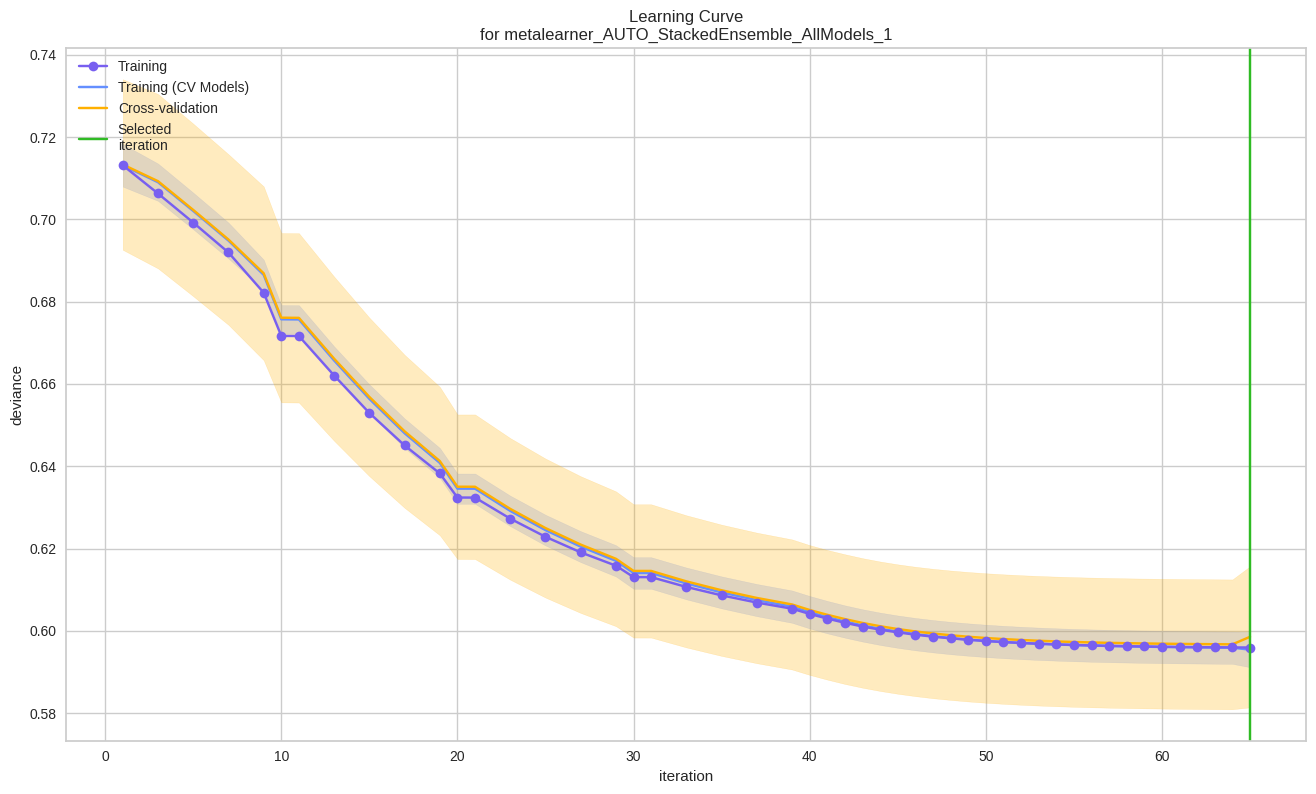

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

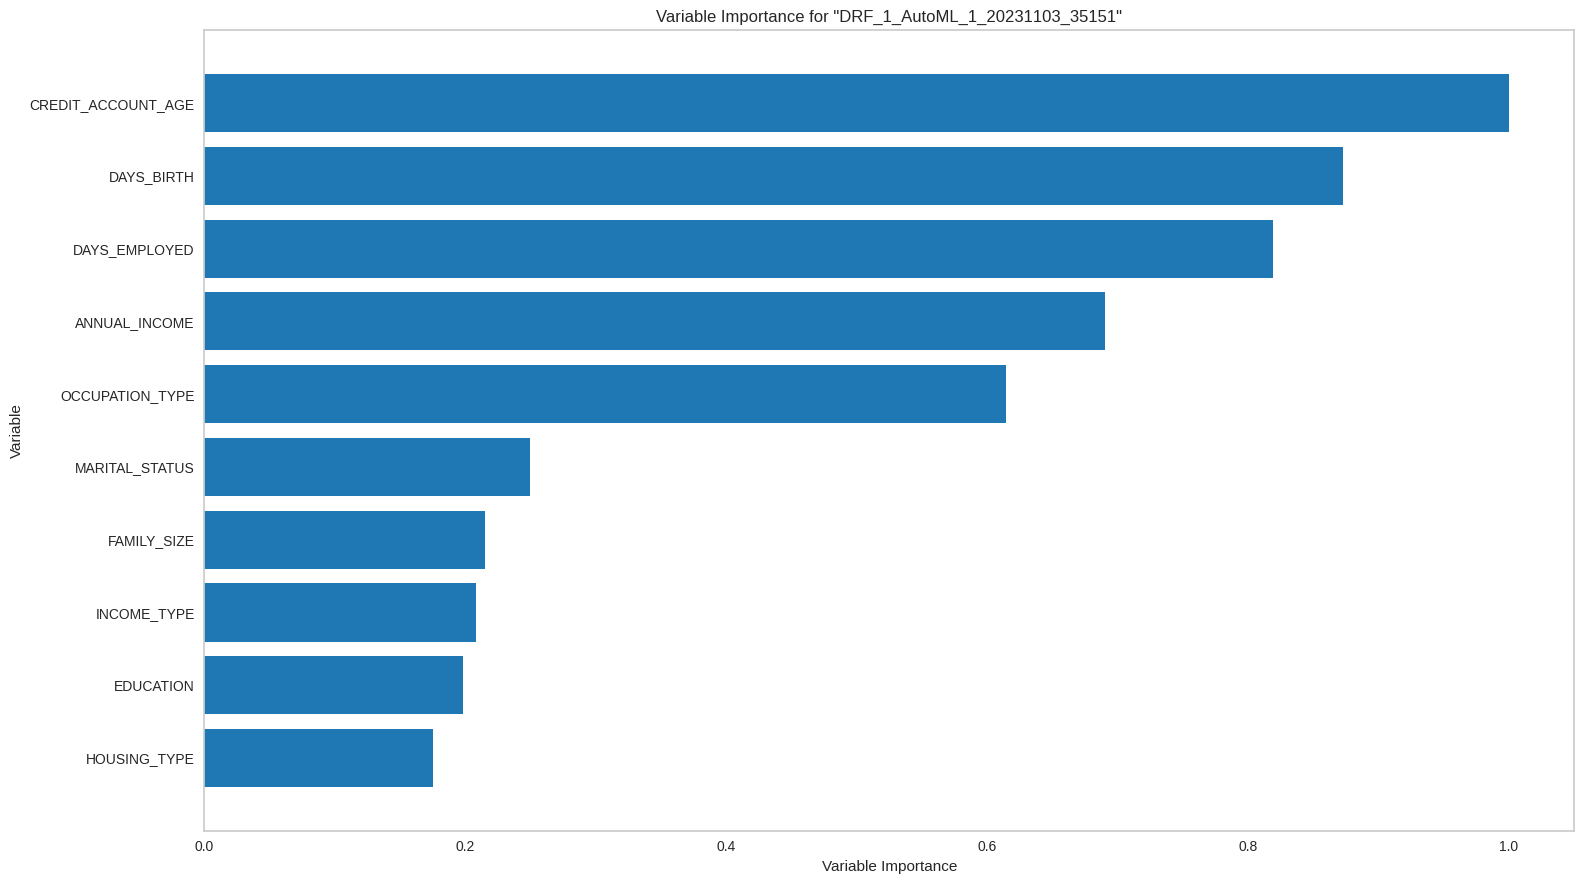

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

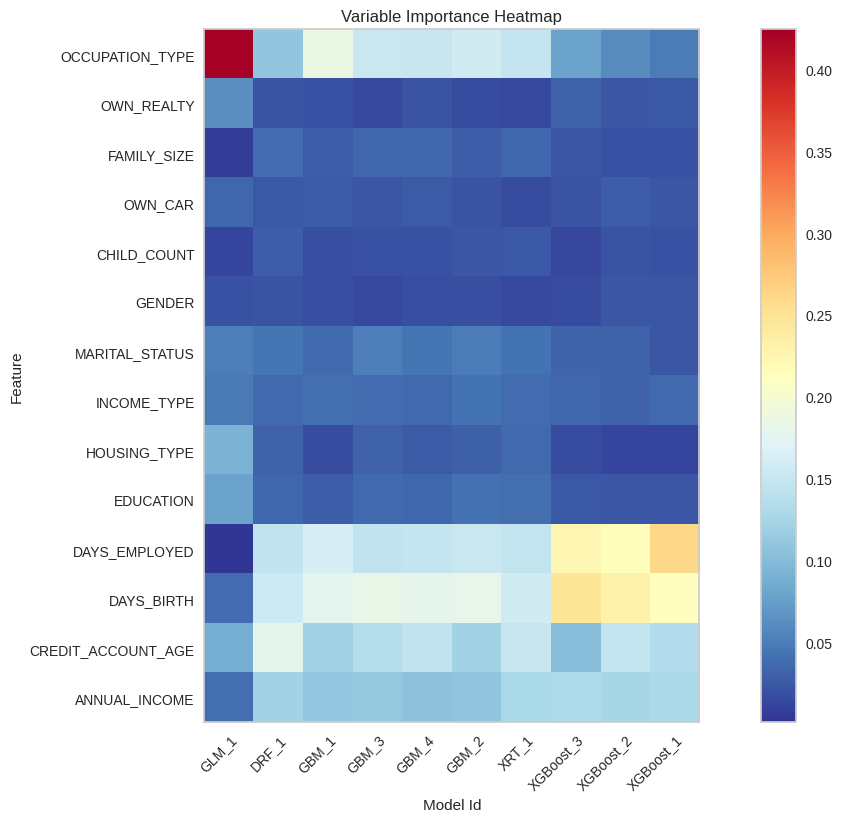

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

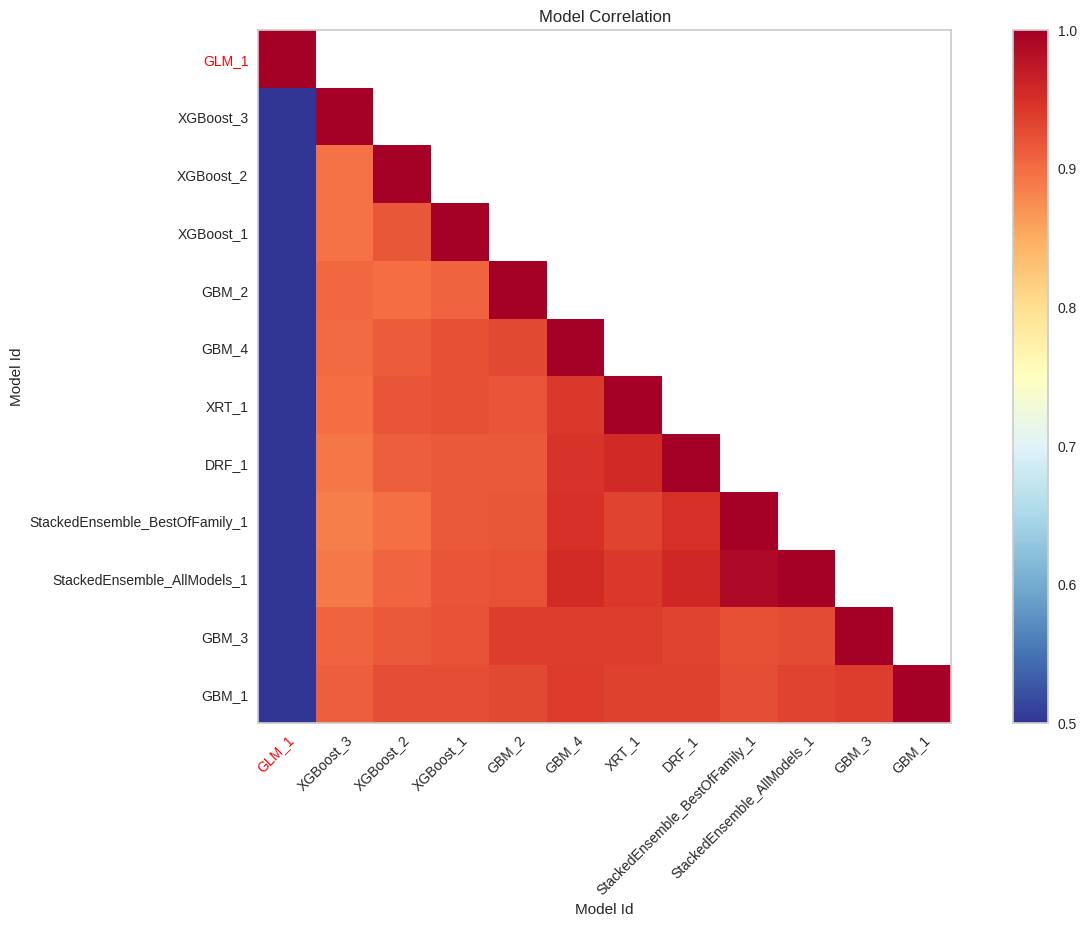

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

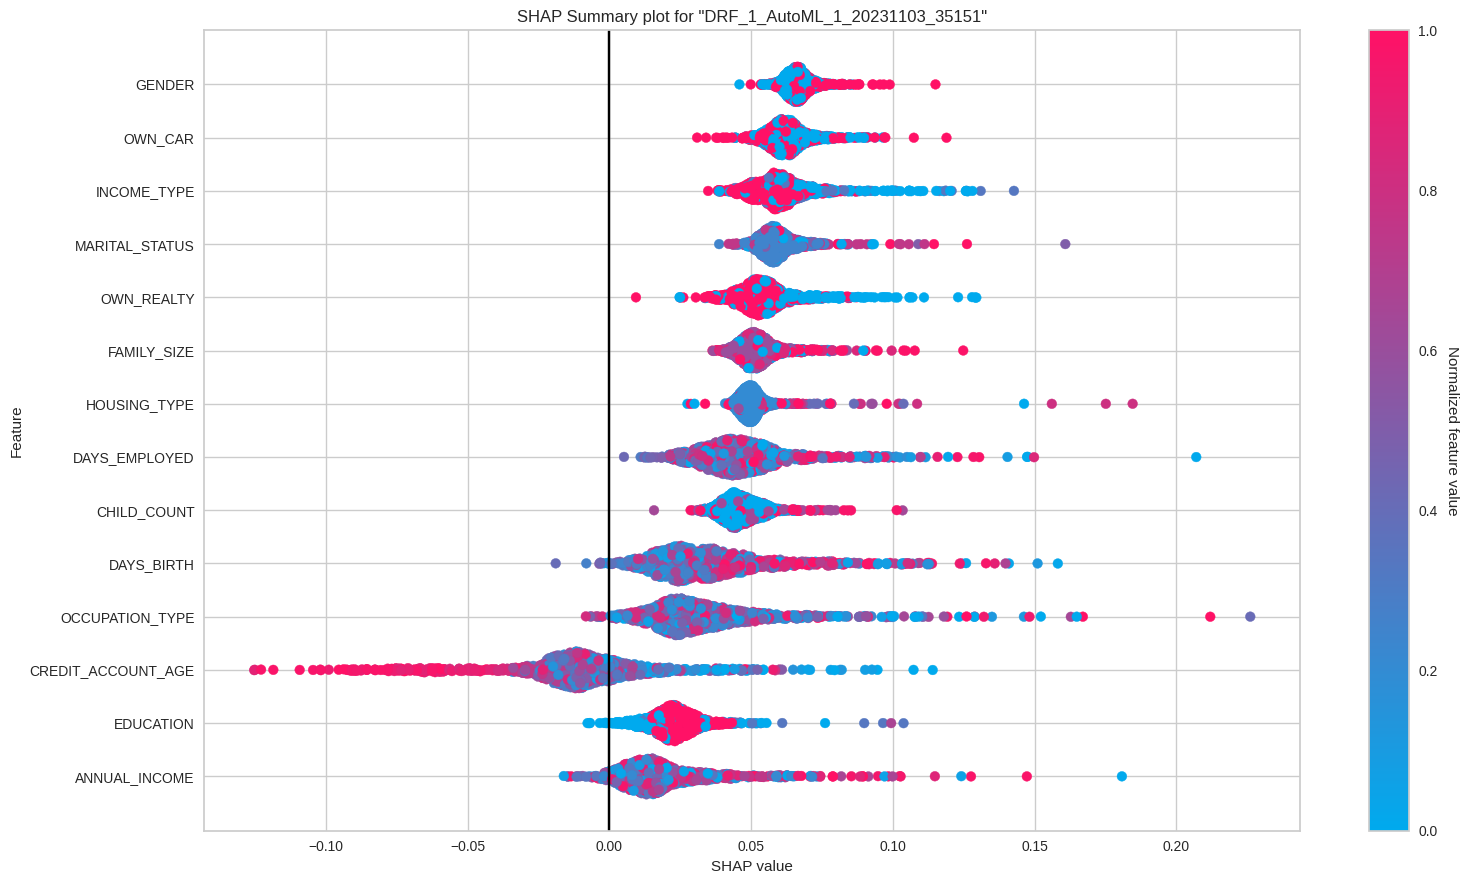

In [ ]:
explain=aml.explain(df_test, exclude_explanations=["pdp","ice","confusion_matrix"])

**Significance of plots**
* Leaderboard: This is a summary of model performance and rankings for different models built during the AutoML process. It provides insights into the best-performing models, helping you choose the most suitable one for your problem.

* Learning Curve Plot: The learning curve plot typically shows how model performance (e.g., AUC or log loss) evolves as the training dataset size increases. It helps assess whether the model could benefit from more data or if it's already saturated.

* Variable Importance Plot: As mentioned earlier, this plot ranks the importance of features in the model. It helps identify influential variables and their impact on predictions.

* Variable Importance Heatmap: This heatmap visualizes the correlation between variables and their importance. It's useful for detecting multicollinearity and understanding how variables collectively contribute to the model.

* Model Correlation: The model correlation plot indicates the correlations between different models in your AutoML run. It helps you assess how similar or dissimilar the models are in terms of predictions, which can be valuable for ensemble learning or model selection.

* SHAP Summary: SHAP (SHapley Additive exPlanations) is a method for understanding the impact of each feature on individual predictions. The SHAP summary provides insights into the contributions of features to specific predictions, helping you interpret the model's behavior.

These plots and summaries are essential for evaluating and understanding the results of your AutoML process in H2O. They provide information about model performance, feature importance, correlations between models, and the impact of features on predictions.

## **Multicollinearity**



After observing the Variable Importance graph for different models we can derive that CREDIT_ACCOUNT_AGE and DAYS_BIRTH are important features to predict the target users.

**Multicollinearity** refers to the situation where two or more independent variables (predictors) in a multiple regression model are highly correlated with each other.
Multicollinearity can be problematic in linear regression because it can make it difficult to isolate the individual effect of each predictor on the dependent variable.

### **Variance Inflation Factor**

VIF is a statistical measure that quantifies the extent of multicollinearity in a multiple regression model.

A high VIF indicates that a predictor variable is highly correlated with other predictors in the model, suggesting the presence of multicollinearity.
Generally, a VIF greater than 1 indicates some level of multicollinearity, and a common threshold for concern is a VIF greater than 5 or 10.

In [ ]:
credit_card_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24891 entries, 0 to 24890
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   ID                  24891 non-null  int64   
 1   GENDER              24891 non-null  object  
 2   OWN_CAR             24891 non-null  object  
 3   OWN_REALTY          24891 non-null  object  
 4   CHILD_COUNT         24891 non-null  int64   
 5   ANNUAL_INCOME       24891 non-null  float64 
 6   INCOME_TYPE         24891 non-null  object  
 7   EDUCATION           24891 non-null  object  
 8   MARITAL_STATUS      24891 non-null  object  
 9   HOUSING_TYPE        24891 non-null  object  
 10  DAYS_BIRTH          24891 non-null  int64   
 11  DAYS_EMPLOYED       24891 non-null  int64   
 12  OCCUPATION_TYPE     24891 non-null  object  
 13  FAMILY_SIZE         24891 non-null  int64   
 14  CREDIT_ACCOUNT_AGE  24891 non-null  int64   
 15  TARGET              24891 non-null  

In [ ]:
#encoding of categorial features

le = LabelEncoder()
for i in credit_card_clean_df.columns:
    if(credit_card_clean_df.dtypes[i] == 'object' or credit_card_clean_df.dtypes[i]=='category'):
        credit_card_clean_df[i] = le.fit_transform(credit_card_clean_df[i])

credit_card_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24891 entries, 0 to 24890
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  24891 non-null  int64  
 1   GENDER              24891 non-null  int64  
 2   OWN_CAR             24891 non-null  int64  
 3   OWN_REALTY          24891 non-null  int64  
 4   CHILD_COUNT         24891 non-null  int64  
 5   ANNUAL_INCOME       24891 non-null  float64
 6   INCOME_TYPE         24891 non-null  int64  
 7   EDUCATION           24891 non-null  int64  
 8   MARITAL_STATUS      24891 non-null  int64  
 9   HOUSING_TYPE        24891 non-null  int64  
 10  DAYS_BIRTH          24891 non-null  int64  
 11  DAYS_EMPLOYED       24891 non-null  int64  
 12  OCCUPATION_TYPE     24891 non-null  int64  
 13  FAMILY_SIZE         24891 non-null  int64  
 14  CREDIT_ACCOUNT_AGE  24891 non-null  int64  
 15  TARGET              24891 non-null  int64  
dtypes: f

In [ ]:
#Indicate which variables to compute VIF
m_collinear = credit_card_clean_df[['GENDER', 'OWN_CAR', 'OWN_REALTY', 'CHILD_COUNT', 'ANNUAL_INCOME', 'INCOME_TYPE', 'EDUCATION', 'MARITAL_STATUS', 'HOUSING_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'FAMILY_SIZE', 'CREDIT_ACCOUNT_AGE','TARGET']]
vif = pd.DataFrame()
vif["variables"] = m_collinear.columns
vif["VIF"] = [variance_inflation_factor(m_collinear.values, i) for i in range(m_collinear.shape[1])]
vif

,variables,VIF
0,GENDER,1.935608
1,OWN_CAR,2.042337
2,OWN_REALTY,3.010811
3,CHILD_COUNT,9.613078
4,ANNUAL_INCOME,5.071992
5,INCOME_TYPE,3.199209
6,EDUCATION,6.606517
7,MARITAL_STATUS,4.872470
8,HOUSING_TYPE,2.773873
9,DAYS_BIRTH,23.179736


VIF for *FAMILY_SIZE* and *DAYS_BIRTH* is greater than 10. However, they are not related to each other.

Nevertheless, we can observe that the VIF of *CHILD_COUNT* is almost 10. *CHILD_COUNT* and *FAMILY_SIZE* are related and hence will be dropping *FAMILY_SIZE* column to reduce multicolinearity.

### **Correlation Matrix**


A correlation matrix is important in machine learning for the following reasons:

* *Identifying Feature Redundancy:* It helps detect and remove highly correlated features, reducing model complexity and multicollinearity.
* *Feature Selection:* Correlation can assist in selecting the most relevant features by identifying those strongly correlated with the target variable.
* *Interpretability:* It provides insights into relationships between features, aiding model understanding and feature engineering decisions.

In [ ]:
corr_df = credit_card_clean_df.corr()
corr_df

,ID,GENDER,OWN_CAR,OWN_REALTY,CHILD_COUNT,ANNUAL_INCOME,INCOME_TYPE,EDUCATION,MARITAL_STATUS,HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,FAMILY_SIZE,CREDIT_ACCOUNT_AGE,TARGET
ID,1.000000,0.002622,-0.025101,-0.086073,0.032837,-0.020000,0.019811,-0.006793,0.010898,0.010931,0.036363,0.022246,0.015124,0.025155,0.000415,0.000163
GENDER,0.002622,1.000000,0.341511,-0.036353,0.021562,0.192456,0.058150,0.042955,-0.058773,0.052033,0.108316,0.127432,-0.016107,0.051385,0.007903,0.010442
OWN_CAR,-0.025101,0.341511,1.000000,0.005777,0.069302,0.198311,0.004349,-0.076746,-0.100224,0.005654,0.073109,0.071721,-0.048703,0.113492,-0.026786,-0.011393
OWN_REALTY,-0.086073,-0.036353,0.005777,1.000000,0.023693,0.034432,-0.025608,-0.001005,0.009169,-0.175080,-0.090221,-0.007401,0.010581,0.020730,0.009637,-0.028025
CHILD_COUNT,0.032837,0.021562,0.069302,0.023693,1.000000,-0.015313,0.027713,-0.027873,-0.156372,0.008796,0.256819,0.065283,-0.005963,0.903029,-0.001915,-0.001971
ANNUAL_INCOME,-0.020000,0.192456,0.198311,0.034432,-0.015313,1.000000,-0.153678,-0.211948,0.027860,-0.018278,-0.058171,-0.021410,0.005511,-0.025157,-0.021293,0.025504
INCOME_TYPE,0.019811,0.058150,0.004349,-0.025608,0.027713,-0.153678,1.000000,0.120513,-0.010153,-0.006944,-0.007189,-0.020935,-0.009399,0.031596,0.003329,-0.018582
EDUCATION,-0.006793,0.042955,-0.076746,-0.001005,-0.027873,-0.211948,0.120513,1.000000,-0.009822,-0.025870,-0.131953,-0.044969,0.096468,-0.018990,0.009864,0.005790
MARITAL_STATUS,0.010898,-0.058773,-0.100224,0.009169,-0.156372,0.027860,-0.010153,-0.009822,1.000000,0.035643,-0.021812,-0.000949,-0.017456,-0.521895,0.038396,-0.000876
HOUSING_TYPE,0.010931,0.052033,0.005654,-0.175080,0.008796,-0.018278,-0.006944,-0.025870,0.035643,1.000000,0.183782,0.067331,-0.030109,-0.013533,0.027720,0.013750


In [ ]:
# Showcasing correlation using heatmap.
fig = px.imshow(corr_df, text_auto=True, color_continuous_scale='rdbu')

# Customize the layout
fig.update_layout(
    title='Feature Correlation Heatmap',
    xaxis_title='Features',
    yaxis_title='Features',
    height=800,
    width=800
)

fig.show()

From the above heatmap, we can confirm that *FAMILY_SIZE* and *CHILD_COUNT* are highly correlated. Hence, after the confirmation, we will drop the *FAMILY_SIZE* column to reduce multicollinearity.

In [ ]:
credit_card_clean_df_processed = credit_card_clean_df.drop(['FAMILY_SIZE'], axis=1)
credit_card_clean_df_processed

,ID,GENDER,OWN_CAR,OWN_REALTY,CHILD_COUNT,ANNUAL_INCOME,INCOME_TYPE,EDUCATION,MARITAL_STATUS,HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,CREDIT_ACCOUNT_AGE,TARGET
0,5008806,1,1,1,0,112500.0,3,4,1,1,-21474,-1134,16,-29,0
1,5008808,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,14,-4,0
2,5008809,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,14,-26,0
3,5008810,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,14,-26,0
4,5008811,0,0,1,0,270000.0,0,4,3,1,-19110,-3051,14,-38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24886,5150464,0,1,1,1,112500.0,3,4,1,1,-14234,-309,3,-21,1
24887,5150465,0,1,1,1,112500.0,3,4,1,1,-14234,-309,3,-10,0
24888,5150466,0,1,1,1,112500.0,3,4,1,1,-14234,-309,3,-1,0
24889,5150467,0,0,1,0,180000.0,3,4,1,1,-17713,-2441,2,-52,0


## **Observations on different models**

In [ ]:
auto_ml_leaderboard = aml.leaderboard
auto_ml_leaderboard

model_id,rmse,auc,logloss,aucpr,mean_per_class_error,mse
StackedEnsemble_AllModels_1_AutoML_1_20231103_35151,0.291914,0.765937,0.298346,0.398376,0.309791,0.085214
StackedEnsemble_BestOfFamily_1_AutoML_1_20231103_35151,0.291915,0.765895,0.298306,0.39824,0.306386,0.0852142
DRF_1_AutoML_1_20231103_35151,0.293345,0.759645,0.305971,0.390753,0.323088,0.0860516
GBM_4_AutoML_1_20231103_35151,0.294723,0.747877,0.306271,0.378288,0.324479,0.0868616
XRT_1_AutoML_1_20231103_35151,0.297205,0.74862,0.308782,0.366652,0.335521,0.0883307
GBM_1_AutoML_1_20231103_35151,0.297328,0.733527,0.310842,0.362851,0.345496,0.0884039
GBM_2_AutoML_1_20231103_35151,0.29966,0.725319,0.314385,0.343052,0.334707,0.0897962
GBM_3_AutoML_1_20231103_35151,0.299712,0.728325,0.314336,0.341682,0.344401,0.0898272
XGBoost_1_AutoML_1_20231103_35151,0.300712,0.723385,0.320607,0.337657,0.348971,0.0904279
XGBoost_2_AutoML_1_20231103_35151,0.30192,0.71651,0.322601,0.327149,0.361971,0.0911554


### **1. Distributed Random Forest - DRF**

In [ ]:
leaderboard_df = auto_ml_leaderboard.as_data_frame()
drf_model_id = leaderboard_df.at[2,"model_id"]
drf_model = h2o.get_model(drf_model_id)
drf_model

Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_1_AutoML_1_20231103_35151


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          1.10711e+06            20           20           20            1334          2074          1754.04

ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.08714657892792471
RMSE: 0.29520599405825876
LogLoss: 0.36239079668873475
Mean Per-Class Error: 0.33192781916890113
AUC: 0.7512151368033188
AUCPR: 0.3820871419229953
Gini: 0.5024302736066375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2557922373018821
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      16337  1386  0.0782   (1386.0/17723.0)
1      1347   953   0.5857   (1347.0/2300.0)
Total  17684  2339  0.1365   (2733.0/20023.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.255792     0.410864  180
max f2                       0.112062     0.479195  275
max f0point5                 0.416534     0.44923   120
max accuracy                 0.557433     0.894122  77
max precision                1            1         0
max recall                   7.40982e-06  1         399
max specificity              1            1         0
max absolute_mcc             0.270564     0.335943  173
max min_per_class_accuracy   0.106168     0.68087   281
max mean_per_class_accuracy  0.150178     0.68922   243
max tns                      1            17723     0
max fns                      1            2290      0
max fps                      7.40982e-06  17723     399
max tps                      7.40982e-06  2300      399
max tnr                      1            1         0
max fnr                      1            0.995652  0
max fpr                      7.40982e-06  1         399
max tpr                      7.40982e-06  1         399

Gains/Lift Table: Avg response rate: 11.49 %, avg score: 11.89 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100385                   0.708787           6.54007   6.54007            0.751244         0.818071    0.751244                    0.818071            0.0656522       0.0656522                  554.007   554.007            0.062831
2        0.020027                    0.606128           5.3975    5.97021            0.62             0.658561    0.685786                    0.738515            0.053913        0.119565                   439.75    497.021            0.112456
3        0.0300155                   0.531492           4.614     5.51889            0.53             0.567883    0.633943                    0.681732            0.046087        0.165652                   361.4     451.889            0.153239
4        0.040004                    0.478477           3.96107   5.12992            0.455            0.504402    0.589263                    0.637455            0.0395652       0.205217                   296.107   412.992            0.186654
5        0.0500425                   0.434628           3.72481   4.84806            0.427861         0.455818    0.556886             

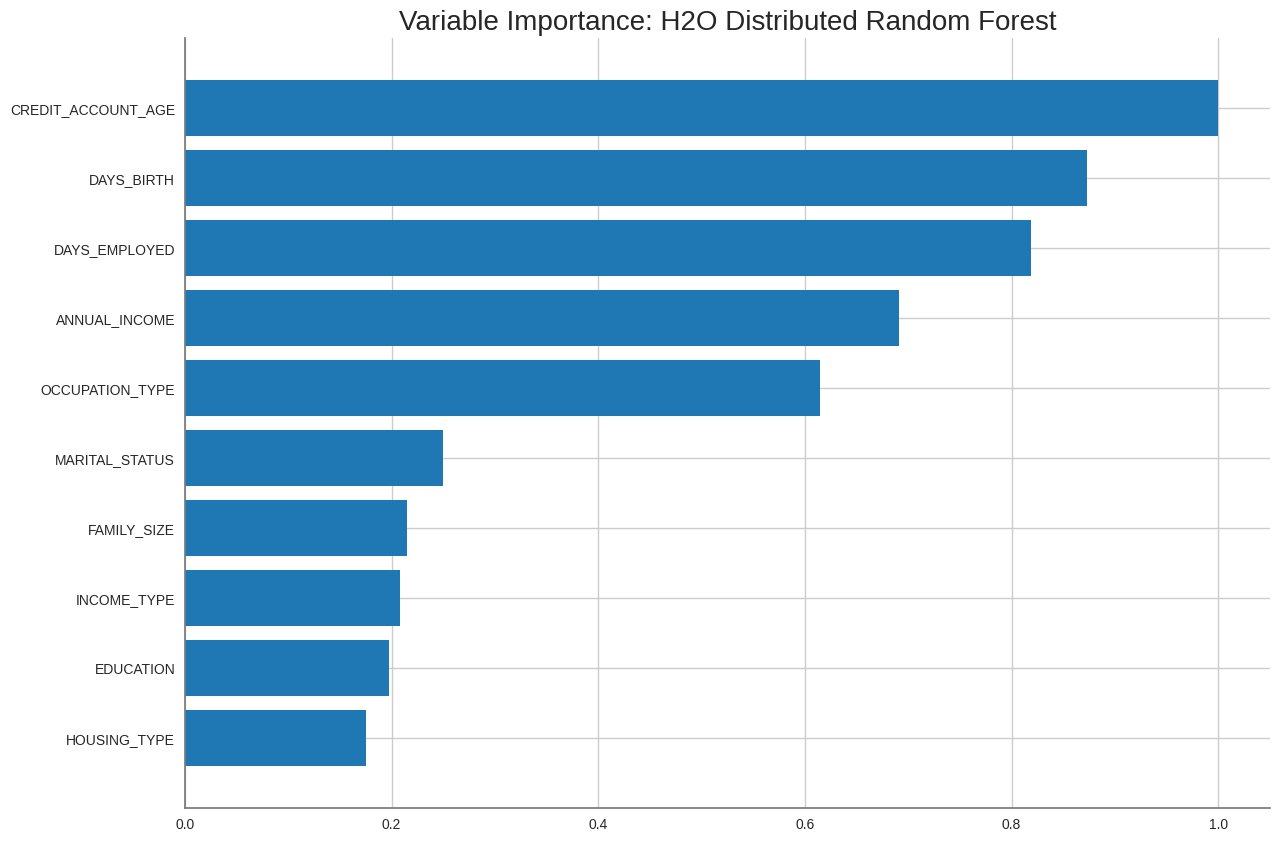

<Figure size 800x550 with 0 Axes>

In [ ]:
drf_model.varimp_plot()

**Model Performance Metrics**
* MSE: 0.08714657892792471
* RMSE: 0.29520599405825876
* LogLoss: 0.36239079668873475
* Mean Per-Class Error: 0.33192781916890113
* AUC: 0.7512151368033188
* AUCPR: 0.3820871419229953
* Gini: 0.5024302736066375

### **2. Gradient Boosting Machines - GBM**

In [ ]:
leaderboard_df = auto_ml_leaderboard.as_data_frame()
gbm_model_id = leaderboard_df.at[3,"model_id"]
gbm_model = h2o.get_model(gbm_model_id)
gbm_model

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_4_AutoML_1_20231103_35151


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    75                 75                          199899                 10           10           10            97            382           207.587

ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.050574127722107586
RMSE: 0.22488692207886965
LogLoss: 0.1810371975339923
Mean Per-Class Error: 0.10524786018659124
AUC: 0.975879770575695
AUCPR: 0.8555577808299609
Gini: 0.9517595411513899

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2190075761383937
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      17013  710   0.0401   (710.0/17723.0)
1      392    1908  0.1704   (392.0/2300.0)
Total  17405  2618  0.055    (1102.0/20023.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.219008     0.775925  202
max f2                       0.166746     0.833135  229
max f0point5                 0.350574     0.796517  146
max accuracy                 0.257117     0.94776   183
max precision                0.974116     1         0
max recall                   0.049666     1         336
max specificity              0.974116     1         0
max absolute_mcc             0.219008     0.746733  202
max min_per_class_accuracy   0.159632     0.92033   233
max mean_per_class_accuracy  0.157975     0.921653  234
max tns                      0.974116     17723     0
max fns                      0.974116     2297      0
max fps                      0.00237994   17723     399
max tps                      0.049666     2300      336
max tnr                      0.974116     1         0
max fnr                      0.974116     0.998696  0
max fpr                      0.00237994   1         399
max tpr                      0.049666     1         336

Gains/Lift Table: Avg response rate: 11.49 %, avg score: 11.47 %
group    cumulative_data_fraction    lower_threshold    lift        cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ----------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100385                   0.771              8.66234     8.66234            0.995025         0.849136   0.995025                    0.849136            0.0869565       0.0869565                  766.234   766.234            0.0869001
2        0.0200769                   0.673714           8.53241     8.59737            0.9801           0.718208   0.987562                    0.783672            0.0856522       0.172609                   753.241   759.737            0.172327
3        0.0300155                   0.593643           8.09319     8.43043            0.929648         0.631453   0.968386                    0.73327             0.0804348       0.253043                   709.319   743.043            0.251971
4        0.040004                    0.529443           8.13978     8.35786            0.935            0.561176   0.96005                     0.6903              0.0813043       0.334348                   713.978   735.786            0.332542
5        0.0500924                   0.468626           7.15415     8.11544            0.821782         0.498894   0.932203   

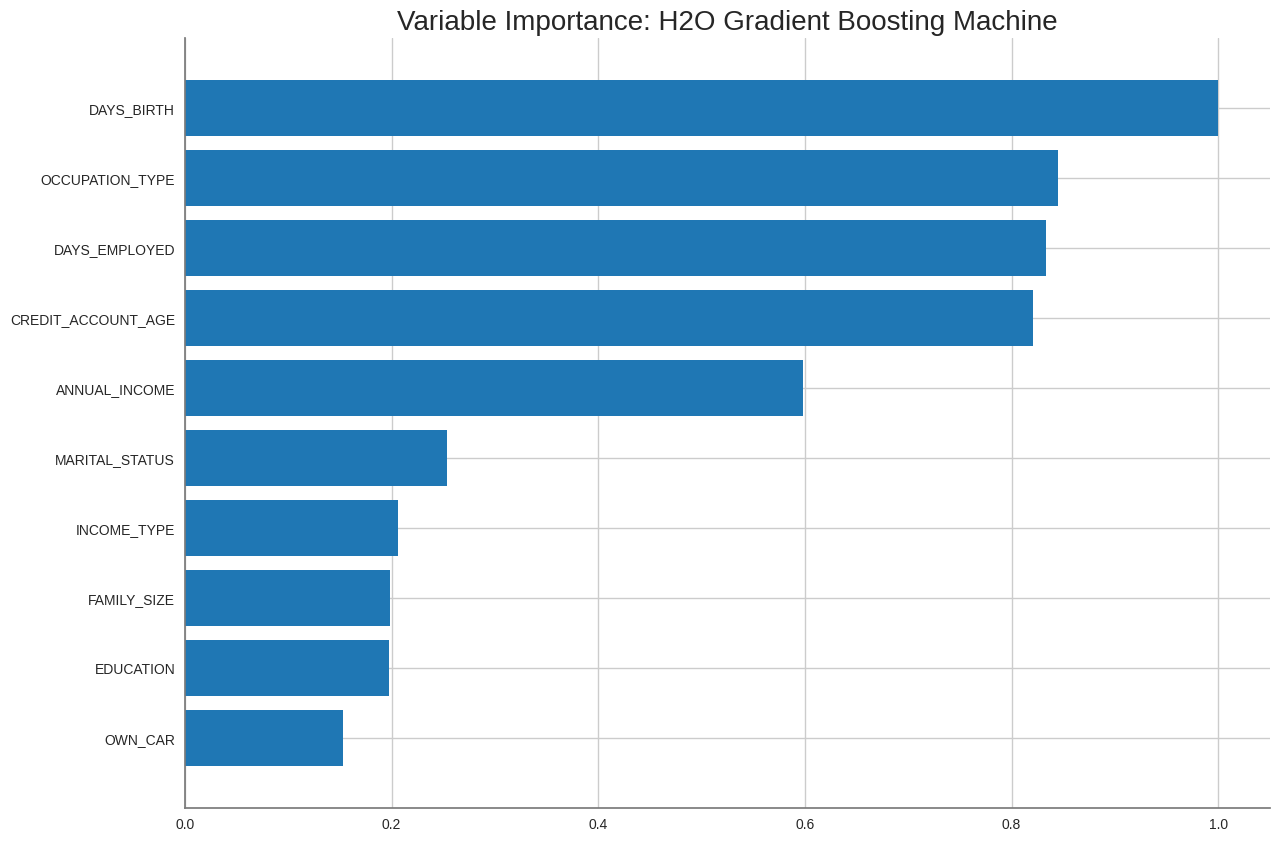

<Figure size 800x550 with 0 Axes>

In [ ]:
gbm_model.varimp_plot()

**Model Performance Metrics**
* MSE: 0.08686164093592837
* RMSE: 0.29472299017200604
* LogLoss: 0.3062706928462132
* Mean Per-Class Error: 0.32447860677233464
* AUC: 0.7478768929590387
* AUCPR: 0.3782883894173673
* Gini: 0.4957537859180774

### **Observation/Conslusion**

Based on above two model Variable Importance plot, we can derive 5  important features as below.


*   CREDIT_ACCOUNT_AGE
*   DAYS_BIRTH
*   DAYS_EMPLOYED
*   ANNUAL_INCOME
*   OCCUPATION_TYPE





## **Assumption Violation Check**
Assumptions in the usage of Distributed Random Forest (DRF) and Gradient Boosting Machine (GBM) are:

1. Independence Assumption: Ensembles like Random Forest and GBM don't explicitly assume independence between observations because they are typically used for predictive modeling rather than statistical inference. Nonetheless, the quality of the data and the choice of features can influence the model's performance.

2. Feature Importance: These models don't assume that all features are equally important. Instead, they rely on feature importance measures to determine the relevance of each variable. Violations of this assumption can occur if irrelevant or highly correlated features are included, leading to less accurate importance rankings.

3. Decision Trees: In both DRF and GBM, decision trees are the base models. These trees assume that the relationship between features and the target variable can be represented by recursive splits based on some criterion (e.g., Gini impurity or information gain). If the true relationship is not tree-like, the models might not perform well.

Distributed Random Forest (DRF) and Gradient Boosting Machine (GBM) are both ensemble machine learning algorithms that don't rely on strong assumptions like linear regression. Therefore, there are no formal tests to check for violations of assumptions in the traditional sense.

**For the DRF model:**

* MSE: 0.08714657892792471
* RMSE: 0.29520599405825876
* LogLoss: 0.36239079668873475
* Mean Per-Class Error: 0.33192781916890113
* AUC: 0.7512151368033188
* AUCPR: 0.3820871419229953
* Gini: 0.5024302736066375

**For the GBM model:**

* MSE: 0.08686164093592837
* RMSE: 0.29472299017200604
* LogLoss: 0.3062706928462132
* Mean Per-Class Error: 0.32447860677233464
* AUC: 0.7478768929590387
* AUCPR: 0.3782883894173673
* Gini: 0.4957537859180774

*Based on these values:*

**MSE and RMSE:** The values for both models are similar and reasonably low, which is a positive sign.

**LogLoss:** The log loss values for both models are relatively close. Lower values are better, but it's essential to consider the context of your problem to determine if these values are satisfactory.

**Mean Per-Class Error:** Both models have a mean per-class error around 0.33 to 0.32. While a lower value is desirable, the consistency between the two models is more important. In this case, the models show similar performance in this metric.

**AUC and AUCPR:** Both models have AUC and AUCPR values around 0.75 and 0.38, respectively. Higher values are better, but the consistency between the models is more crucial. In this case, the models exhibit similar performance in these metrics.

**Gini:** The Gini index values for both models are around 0.50. Higher values are desirable, and the models are consistent in this metric.

**Overall, the metrics for both the DRF and GBM models appear to be satisfactory, and the consistency in performance between the two models is a positive sign. So, we can conclude that no assumptions were violated.**

## **Questions/Answers to the assignment**

1. Is the relationship significant?

  Based on both DRF and GBM models, we derived that importat features are CREDIT_ACCOUNT_AGE, DAYS_BIRTH, DAYS_EMPLOYED, ANNUAL_INCOME, OCCUPATION_TYPE. Since both the models have shown the consistency in metrics, we can conclude that the relationship is significant.


2. Are any model assumptions violated?

  Both DRF and GBM suggested same 5 important variables for prediction. Hence, feature importance is not violated. For the decision tree splits, Gini impurity is important. In both the models, the gini impurity is near 0.5. This suggests a mixed node where data points are evenly distributed across multiple classes. This is less ideal as it implies uncertainty in classification.


3. Is there any multicollinearity in the model?

  In the initial dataset, there were multicollinearity. However, through VIF and Heatmap correlation matrix, the multicollinearity was identified and irrelevant column(FAMILY_SIZE) was removed.


4. In the multivariate models are predictor variables independent of all the other predictor variables?

  In the process of finding multicollinearity, we observed that CHILD_COUNT and FAMILY_SIZE were highly dependent on each other. Hence, we dropped the FAMILY_SIZE column. Other than these 2, other variables are independent of each other.

5. In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

  In DRF and GBM model Variable Importance plots, we can clearly see the 5 important features are CREDIT_ACCOUNT_AGE, DAYS_BIRTH, DAYS_EMPLOYED, ANNUAL_INCOME, OCCUPATION_TYPE. In VIF, we could see that FAMILY_SIZE had a value around 43. Hence, FAMILY_SIZE variable was excluded forfurther analysis.


6. Does the model make sense?
The metrics for both the DRF and GBM models appear to be satisfactory, and the consistency in performance between the two models. Also the RMSE values are significantly low, hence we can conclude that the model does make sense.

7. Does regularization help?
In ensemble models like Random Forest and Gradient Boosting (including GBM and XGBoost), regularization techniques can be more explicitly applied.
In such models, regularization can help control the complexity of the individual trees that make up the ensemble, preventing them from overfitting.

8. Which independent variables are significant?

  With the models and analysis, 5 important variables are CREDIT_ACCOUNT_AGE, DAYS_BIRTH, DAYS_EMPLOYED, ANNUAL_INCOME, OCCUPATION_TYPE.

9. Which hyperparameters are important?

  According to the above assessment, crucial hyperparameters comprise CREDIT_ACCOUNT_AGE, DAYS_BIRTH, DAYS_EMPLOYED, ANNUAL_INCOME, and OCCUPATION_TYPE.

##**LICENSE**

MIT License

Copyright (c) [2023] [Muskan Raisinghani]

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS," WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

##**REFERENCES**

H20.ai- https://docs.h2o.ai/ <br>
Kaggle Dataset- https://www.kaggle.com/code/rikdifos/credit-card-approval-prediction-using-ml/ <br>
Kaggle notebook - https://www.kaggle.com/code/rikdifos/credit-card-approval-prediction-using-ml/notebook <br>
Professor's AutoML Notebook- https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/CC_Kaggle_AutoML_Regression_Melbourne_Housing.ipynb